In [2]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import matplotlib.pyplot as plt

%matplotlib inline

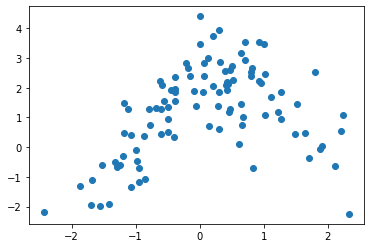

In [5]:
# Create dummy data.
num_data = 100
X = np.random.randn(num_data, 1)  # [N, 2]
Y = np.sin(X) + 2 * np.cos(X) + np.random.randn(*X.shape)  # [N, 1]
plt.plot(X, Y, "o")

In [7]:
# Set up model and print
kernel = gpflow.kernels.SquaredExponential(lengthscales=[1.0, 2.0]) + gpflow.kernels.Linear()
model = gpflow.models.GPR((X, Y), kernel)
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(2,)",float64,[1. 2.]
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [10]:
Y.shape

(100, 1)

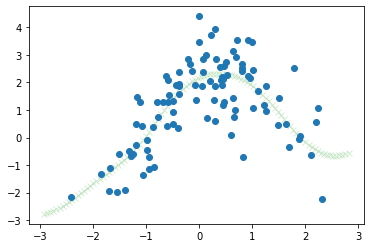

In [8]:
# We define a function that plots the model's prediction (in the form of samples) together with the data.
# Importantly, this function has no other argument than `fig: matplotlib.figure.Figure` and `ax: matplotlib.figure.Axes`.


def plot_prediction(fig, ax):
    Xnew = np.linspace(X.min() - 0.5, X.max() + 0.5, 100).reshape(-1, 1)
    Ypred = model.predict_f_samples(Xnew, full_cov=True, num_samples=1)
    ax.plot(Xnew.flatten(), np.squeeze(Ypred).T, "C2", linestyle='none', marker='x', alpha=0.2)
    ax.plot(X, Y, "o")


# Let's check if the function does the desired plotting
fig = plt.figure()
ax = fig.subplots()
plot_prediction(fig, ax)
plt.show()

In [ ]:
Xnew = np.linspace(X.min() - 0.5, X.max() + 0.5, 100).reshape(-1, 1)
Ypred = model.predict_f_samples(Xnew, full_cov=True, num_samples=100)

In [ ]:
Xnew.shape

In [ ]:
Ypred

In [ ]:
np.squeeze(Ypred).T.shape

In [ ]:
Ypred.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
X = np.random.randn(num_data, 1)  # [N, 2]
Y = np.sin(X) + 2 * np.cos(X) + np.random.randn(*X.shape) * noise_std  # [N, 1]

_ = plt.plot(X, Y, "kx", mew=2)

In [ ]:
k = gpflow.kernels.Matern52()

In [ ]:
print_summary(k)

In [ ]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

In [ ]:
m.likelihood.variance.assign(0.01)
m.kernel.lengthscales.assign(0.3)

In [ ]:
opt = gpflow.optimizers.Scipy()

In [ ]:
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)

In [ ]:
X.shape, Y.shape

In [ ]:
## generate test points for prediction
xx = np.linspace(-2, 2, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.plot(xx, mean, "C2", linestyle='none', marker='x')
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C3",
    alpha=0.2,
)

plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
_ = plt.xlim(-2, 2)

In [ ]:
mean

In [ ]:
xx

In [148]:
import pandas as pd
import numpy as np

In [149]:
data = pd.read_csv("~/data/plasticc/training_set.csv", sep=',')
data.shape

(1421705, 6)

In [150]:
data = data.loc[data.detected == 1]  # Update dataframe with only detected points

In [151]:
data.shape

(236880, 6)

In [152]:
def remap_filters(df):  # maybe not in snmachine (raise issue/channel)
    """Function to remap integer filters to the corresponding lsst filters and
    also to set filter name syntax to what snmachine already recognizes

    df: pandas.dataframe
        Dataframe of lightcurve observations
    """
    df.rename({'passband': 'filter'}, axis='columns', inplace=True)
    filter_replace = {0: 'lsstu', 1: 'lsstg', 2: 'lsstr', 3: 'lssti',
                      4: 'lsstz', 5: 'lssty'}
    df['filter'].replace(to_replace=filter_replace, inplace=True)
    return df


In [153]:
data = remap_filters(df=data)
data.rename({'flux_err': 'flux_error'}, axis='columns', inplace=True)  # snmachine and PLAsTiCC uses a different denomination
data.head()

,object_id,mjd,filter,flux,flux_error,detected
0,615,59750.4229,lsstr,-544.810303,3.622952,1
1,615,59750.4306,lsstg,-816.434326,5.553370,1
2,615,59750.4383,lssti,-471.385529,3.801213,1
3,615,59750.4450,lsstz,-388.984985,11.395031,1
4,615,59752.4070,lsstr,-681.858887,4.041204,1


In [154]:
import re
# Abstract column names from dataset
for col in data.columns:
    if re.search('mjd', col):  # catches the column that has `mjd` in its name
        data.mjd_col = col
    if re.search('id', col):  # catches the column that has `id` in its name
        data.id_col = col

In [155]:
data.id_col

'object_id'

In [156]:
number_invalid_objs = 0  # Some objects may have empty data
number_objs = len(data[data.id_col].unique())
object_names = []

In [157]:
data

,object_id,mjd,filter,flux,flux_error,detected
0,615,59750.4229,lsstr,-544.810303,3.622952,1
1,615,59750.4306,lsstg,-816.434326,5.553370,1
2,615,59750.4383,lssti,-471.385529,3.801213,1
3,615,59750.4450,lsstz,-388.984985,11.395031,1
4,615,59752.4070,lsstr,-681.858887,4.041204,1
...,...,...,...,...,...,...
1421641,130779836,60133.3766,lssti,304.545258,28.338671,1
1421642,130779836,60137.1041,lssti,305.615570,28.171988,1
1421643,130779836,60138.1329,lssti,270.237976,28.013514,1
1421645,130779836,60142.1321,lssti,276.659332,27.884199,1


In [158]:
import matplotlib.pyplot as plt
%matplotlib inline

In [159]:
data.head()

,object_id,mjd,filter,flux,flux_error,detected
0,615,59750.4229,lsstr,-544.810303,3.622952,1
1,615,59750.4306,lsstg,-816.434326,5.553370,1
2,615,59750.4383,lssti,-471.385529,3.801213,1
3,615,59750.4450,lsstz,-388.984985,11.395031,1
4,615,59752.4070,lsstr,-681.858887,4.041204,1


In [160]:
filters = data['filter']
filters = list(np.unique(filters))
filters

['lsstg', 'lssti', 'lsstr', 'lsstu', 'lssty', 'lsstz']

In [161]:
data

,object_id,mjd,filter,flux,flux_error,detected
0,615,59750.4229,lsstr,-544.810303,3.622952,1
1,615,59750.4306,lsstg,-816.434326,5.553370,1
2,615,59750.4383,lssti,-471.385529,3.801213,1
3,615,59750.4450,lsstz,-388.984985,11.395031,1
4,615,59752.4070,lsstr,-681.858887,4.041204,1
...,...,...,...,...,...,...
1421641,130779836,60133.3766,lssti,304.545258,28.338671,1
1421642,130779836,60137.1041,lssti,305.615570,28.171988,1
1421643,130779836,60138.1329,lssti,270.237976,28.013514,1
1421645,130779836,60142.1321,lssti,276.659332,27.884199,1


In [162]:
data[data['object_id'] == 1920].shape

(55, 6)

In [163]:
colours = {
    'lsstu': '#9a0eea', 
    'lsstg': '#75bbfd', 
    'lsstr': '#76ff7b',
    'lssti': '#fdde6c', 
    'lsstz': '#f97306', 
    'lssty': '#e50000'
}

In [164]:
print(colours['lsstu'])

#9a0eea


In [165]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [166]:
def plot_object(object_name, df, filters):
    for passband in filters:
        data = df[df['object_id'] == object_name]
        data = data[data['filter'] == passband]
        #print(data.head())
        plt.errorbar(x=data['mjd'], y=data['flux'], yerr=data['flux_error'], 
                     linestyle='none', 
                     marker='o', 
                     color=colours[passband]
                    )

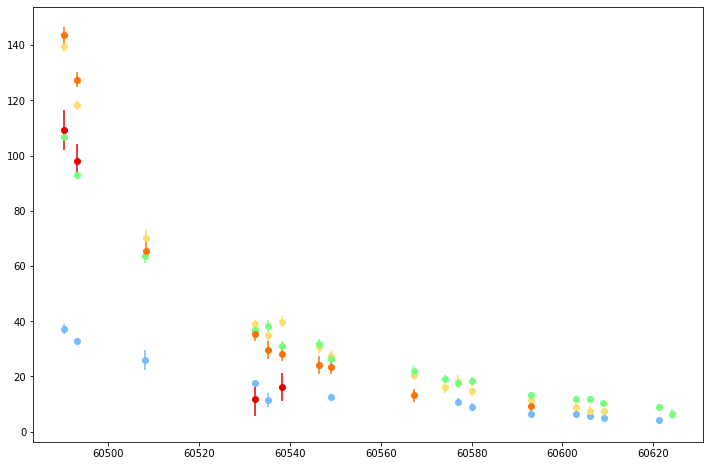

In [168]:
plot_object(1124, data, filters)

In [169]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import matplotlib.pyplot as plt

%matplotlib inline

In [170]:
object_name = 745

df = data[data['object_id'] == object_name]
df = df[df['filter'] == 'lsstr']
df['flux'].shape, df['flux_error'].shape

((16,), (16,))

In [171]:
y = df['flux']
y_err = df['flux_error']
y.shape, y_err.shape

((16,), (16,))

In [172]:
y = y.values.reshape(y.shape[0], 1)
y_err = y_err.values.reshape(y_err.shape[0], 1)
y.shape, y_err.shape

((16, 1), (16, 1))

In [173]:
# y.shape, Y.shape

In [174]:
Y_data = np.hstack([y, y_err])
Y_data.shape

(16, 2)

In [175]:
mjd = df['mjd']
obj_wavelengths = df['filter'].map(pb_wavelengths)

In [176]:
obj_wavelengths = obj_wavelengths.values.reshape(obj_wavelengths.shape[0], 1)
mjd = mjd.values.reshape(mjd.shape[0], 1)

In [177]:
mjd.shape

(16, 1)

In [216]:
X = np.hstack([mjd, obj_wavelengths])
X.shape

(16, 2)

In [200]:
# X = X.values.reshape(X.shape[0], 1)
# X.shape

In [213]:
n_grid = 30
x = np.linspace(-10, 10, n_grid)
X, Y = np.meshgrid(x, x)
X = np.vstack((X.flatten(), Y.flatten())).T
X.shape

(900, 2)

In [201]:
class HeteroskedasticGaussian(gpflow.likelihoods.Likelihood):
    def __init__(self, **kwargs):
        # this likelihood expects a single latent function F, and two columns in the data matrix Y:
        super().__init__(latent_dim=1, observation_dim=2, **kwargs)

    def _log_prob(self, H, Y):
        # log_prob is used by the quadrature fallback of variational_expectations and predict_log_density.
        # Because variational_expectations is implemented analytically below, this is not actually needed,
        # but is included for pedagogical purposes.
        # Note that currently relying on the quadrature would fail due to https://github.com/GPflow/GPflow/issues/966
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        return gpflow.logdensities.gaussian(Y, H, NoiseVar)

    def _variational_expectations(self, Fmu, Fvar, Y):
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        Fmu, Fvar = Fmu[:, 0], Fvar[:, 0]
        return (
            -0.5 * np.log(2 * np.pi)
            - 0.5 * tf.math.log(NoiseVar)
            - 0.5 * (tf.math.square(Y - Fmu) + Fvar) / NoiseVar
        )

    # The following two methods are abstract in the base class.
    # They need to be implemented even if not used.

    def _predict_log_density(self, Fmu, Fvar, Y):
        raise NotImplementedError

    def _predict_mean_and_var(self, Fmu, Fvar):
        raise NotImplementedError

In [212]:
Y_data.shape, X.shape

((16, 2), (16, 2))

In [203]:
# X = (X - X.mean()) / X.std()
# Y_data = (Y_data - Y_data.mean()) / Y_data.std()

In [204]:
np.isnan(np.sum(Y_data)), np.isnan(np.sum(X))

(False, False)

In [217]:
# model construction
likelihood = HeteroskedasticGaussian()
# kernel = gpflow.kernels.Matern52(lengthscales=0.5)
kernel = gpflow.kernels.Matern52(active_dims=[0], lengthscales=2) + gpflow.kernels.Matern52(active_dims=[1], lengthscales=2)
    
model = gpflow.models.VGP((X, Y_data), kernel=kernel, likelihood=likelihood, num_latent_gps=1)

In [218]:
model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,2.0
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,2.0
VGP.q_mu,Parameter,Identity,,True,"(16, 1)",float64,[[0....
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[1., 0., 0...."


In [219]:
m = model
m

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,2.0
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,2.0
VGP.q_mu,Parameter,Identity,,True,"(16, 1)",float64,[[0....
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[1., 0., 0...."


In [220]:
set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

In [221]:
opt = gpflow.optimizers.Scipy()

In [222]:
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))

In [223]:
from gpflow.utilities import print_summary
# You can change the default format as follows:
gpflow.config.set_default_summary_fmt("notebook")
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.829018320073424e-06
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,2.0
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.8290183200734208e-06
VGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,2.0
VGP.q_mu,Parameter,Identity,,False,"(16, 1)",float64,[[0....
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 16, 16)",float64,"[[[1., 0., 0...."


In [224]:
# natgrad = NaturalGradient(gamma=1.0)
# adam = tf.optimizers.Adam()

In [225]:
# for _ in range(ci_niter(1000)):
#     natgrad.minimize(model.training_loss, [(model.q_mu, model.q_sqrt)])
#     adam.minimize(model.training_loss, model.trainable_variables)

In [232]:
y_err.shape, X.shape, y.shape

((16, 1), (16, 2), (16, 1))

In [227]:
X[0].min().round(), X[0].max().round()

(6231.0, 60125.0)

In [228]:
X[:, 0]

array([60125.4094, 60153.2828, 60164.1619, 60168.1735, 60181.3618,
       60184.3051, 60194.1098, 60197.0703, 60208.0724, 60211.0601,
       60221.0629, 60224.0614, 60227.0626, 60237.2675, 60240.0698,
       60249.0813])

In [233]:
del mu, var

In [235]:
#let's do some plotting!
xx = np.linspace(X[:, 0].min().round(), X[:, 0].max().round(), 200)[:, None]

In [248]:
obj_wavelengths[0]

array([18693.])

In [254]:
data_tensor = tf.ragged.constant(xx)
data_tensor.to_tensor()

<tf.Tensor: shape=(200, 1), dtype=float64, numpy=
array([[60125.        ],
       [60125.62311558],
       [60126.24623116],
       [60126.86934673],
       [60127.49246231],
       [60128.11557789],
       [60128.73869347],
       [60129.36180905],
       [60129.98492462],
       [60130.6080402 ],
       [60131.23115578],
       [60131.85427136],
       [60132.47738693],
       [60133.10050251],
       [60133.72361809],
       [60134.34673367],
       [60134.96984925],
       [60135.59296482],
       [60136.2160804 ],
       [60136.83919598],
       [60137.46231156],
       [60138.08542714],
       [60138.70854271],
       [60139.33165829],
       [60139.95477387],
       [60140.57788945],
       [60141.20100503],
       [60141.8241206 ],
       [60142.44723618],
       [60143.07035176],
       [60143.69346734],
       [60144.31658291],
       [60144.93969849],
       [60145.56281407],
       [60146.18592965],
       [60146.80904523],
       [60147.4321608 ],
       [60148.05527638],


In [269]:
w = [6231.] * 200
W = np.array(w)
W = W.reshape(W.shape[0], 1)

In [270]:
mu, var = m.predict_f([data_tensor.to_tensor(), W])

InvalidArgumentError: indices[0] = 1 is not in [0, 1) [Op:GatherV2]

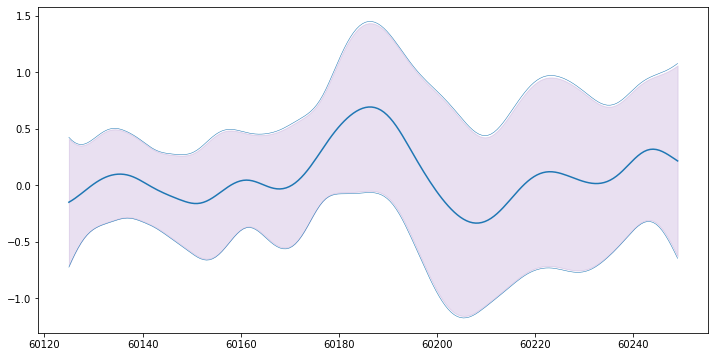

In [146]:
plt.figure(figsize=(12, 6))
plt.plot(xx, mu, "C0")
plt.plot(xx, mu + 2 * np.sqrt(var), "C0", lw=0.5)
plt.plot(xx, mu - 2 * np.sqrt(var), "C0", lw=0.5)
plt.fill_between(
    xx[:, 0],
    mu[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mu[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C4",
    alpha=0.2,
)

In [147]:
#let's do some plotting!
xx = np.linspace(X[:, 0].min().round(), X[:, 0].max().round(), 200)[:, None]

mu, var = m.predict_f(xx)

plt.figure(figsize=(12, 6))
plt.plot(xx, mu, "C0")
plt.plot(xx, mu + 2 * np.sqrt(var), "C0", lw=0.5)
plt.plot(xx, mu - 2 * np.sqrt(var), "C0", lw=0.5)

plt.fill_between(
    xx[:, 0],
    mu[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mu[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C4",
    alpha=0.2,
)

InvalidArgumentError: Matrix size-incompatible: In[0]: [16,2], In[1]: [1,200] [Op:MatMul]

In [65]:
# Central passbands wavelengths
pb_wavelengths = {"lsstu": 3685., "lsstg": 4802., "lsstr": 6231.,
                  "lssti": 7542., "lsstz": 8690., "lssty": 9736.}


In [292]:
np.random.seed(1)  # for reproducibility


def generate_data(N=80):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs, shape N x 1
    X2 = [1500] * N
    X2 = np.array(X2)
    X2 = X2.reshape(X2.shape[0], 1)
    F = 2.5 * np.sin(6 * X) + np.cos(3 * X)  # Mean function values
    NoiseVar = 2 * np.exp(-((X - 2) ** 2) / 4) + 0.3  # Noise variances
    Y = np.random.randn(N, 1) * np.sqrt(NoiseVar)  # Noisy data
    return X, Y, NoiseVar, X2


X, Y, NoiseVar, X2 = generate_data()

In [ ]:
X.shape, X2.shape, Y.shape

In [302]:
Y.shape

(80, 1)

In [295]:
Y_data = np.hstack([Y, NoiseVar])

In [296]:
Y_data.shape

(80, 2)

In [297]:
XX = np.hstack([X, X2])
XX.shape

(80, 2)

In [298]:
# model construction
likelihood = HeteroskedasticGaussian()
# kernel = gpflow.kernels.Matern52(lengthscales=0.5)
kernel = gpflow.kernels.Matern52(active_dims=[0], lengthscales=0.5) + gpflow.kernels.Matern52(active_dims=[1], lengthscales=0.5)
model = gpflow.models.VGP((XX, Y_data), kernel=kernel, likelihood=likelihood, num_latent_gps=1)

In [299]:
model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.5
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.5
VGP.q_mu,Parameter,Identity,,True,"(80, 1)",float64,[[0....
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 80, 80)",float64,"[[[1., 0., 0...."


In [300]:
natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam()

set_trainable(model.q_mu, False)
set_trainable(model.q_sqrt, False)

for _ in range(ci_niter(1000)):
    natgrad.minimize(model.training_loss, [(model.q_mu, model.q_sqrt)])
    adam.minimize(model.training_loss, model.trainable_variables)

In [301]:
# let's do some plotting!
xx = np.linspace(-5, 5, 200)[:, None]

mu, var = model.predict_f(xx)

plt.figure(figsize=(12, 6))
plt.plot(xx, mu, "C0")
plt.plot(xx, mu + 2 * np.sqrt(var), "C0", lw=0.5)
plt.plot(xx, mu - 2 * np.sqrt(var), "C0", lw=0.5)

plt.errorbar(
    X.squeeze(),
    Y.squeeze(),
    yerr=2 * (np.sqrt(NoiseVar)).squeeze(),
    marker="x",
    lw=0,
    elinewidth=1.0,
    color="C1",
)
_ = plt.xlim(-5, 5)

InvalidArgumentError: indices[0] = 1 is not in [0, 1) [Op:GatherV2]

In [49]:
np.isnan(np.sum(Y_data)), np.isnan(np.sum(X))

(False, False)

In [2]:
import snmachine
import pickle
    
augmented_binary =  f"../data/plasticc/aug_z_new_long_many_obs_35k.pckl"

with open(augmented_binary, "rb") as f:
    aug = pickle.load(f)

In [3]:
aug.metadata

,ra,decl,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,object_id,augmented,original_event
730_aug1,33.5742,-6.5796,False,0.706679,0.712679,0.012493,40.256,0.021,42,42,2,730_aug1,True,730
730_aug18,33.5742,-6.5796,False,0.300172,0.285172,0.0164796,40.256,0.021,42,42,2,730_aug18,True,730
730_aug24,33.5742,-6.5796,False,0.148389,0.146389,0.0223689,40.256,0.021,42,42,2,730_aug24,True,730
1632_aug12,348.596,-63.0726,False,1.30495,1.39895,0.0381622,43.152,0.021,42,42,3,1632_aug12,True,1632
2103_aug0,346.5,-62.3204,False,0.424507,0.329507,0.800993,42.467,0.02,42,42,2,2103_aug0,True,2103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130639669_aug73,164.004,-31.0392,False,0.446786,0.549786,0.439827,40.825,0.07,62,62,2,130639669_aug73,True,130639669
130639669_aug75,164.004,-31.0392,False,0.251452,0.236452,0.00931878,40.825,0.07,62,62,2,130639669_aug75,True,130639669
130639669_aug76,164.004,-31.0392,False,0.176224,0.167224,0.0498352,40.825,0.07,62,62,2,130639669_aug76,True,130639669
130639669_aug78,164.004,-31.0392,False,0.3472,0.3542,0.262582,40.825,0.07,62,62,2,130639669_aug78,True,130639669


In [117]:
from collections import Counter
Counter(aug.metadata['target'])

Counter({42: 11840, 90: 11840, 62: 11840})

In [118]:
meta = aug.metadata

In [81]:
from astronet.utils import *

In [7]:
object_list = list(aug.object_names)
object_list[:5]

['730_aug1', '730_aug18', '730_aug24', '1632_aug12', '2103_aug0']

In [13]:
cols = list(aug.data[object_list[0]].to_pandas().columns)
cols

['object_id',
 'mjd',
 'filter',
 'flux',
 'flux_error',
 'detected',
 'ref_mjd',
 'wavelength_z_ori']

In [14]:
adf = pd.DataFrame(data=[], columns=cols,)

In [19]:
aug.data[object_list[0]]

object_id,mjd,filter,flux,flux_error,detected,ref_mjd,wavelength_z_ori
str8,float64,str5,float64,float64,bool,float64,float64
730_aug1,0.0,lsstr,2.2145400691719135,9.068648625878922,False,2.9783000000024913,4497.971664681429
730_aug1,0.021472011655098378,lssti,-0.8101533576916186,2.4233469198029143,False,2.99380000000383,5444.343170442518
730_aug1,4.159197921783688,lsstr,-1.158885311237583,6.427957765473942,False,5.98070000000007,4497.971664681429
730_aug1,4.169864663059267,lsstg,-1.016922387079945,3.5486067751154073,False,5.988400000002002,3466.4195047023304
730_aug1,4.210869278863896,lssty,-33.43232124872952,26.18549688031617,False,6.018000000003667,7028.12584293667
730_aug1,26.29961251842442,lsstu,8.379986600426404,9.299289315545403,False,21.963199999998324,2660.0907694352536
730_aug1,30.409909665287355,lsstu,-10.576248237859161,9.997013321232883,False,24.93029999999999,2660.0907694352536
730_aug1,31.796586030769898,lsstu,1.0806700852793394,11.550870178793286,False,25.93130000000383,2660.0907694352536
730_aug1,33.17384241694257,lsstu,5.377006074950055,8.229886379752006,False,26.92550000000483,2660.0907694352536


In [32]:
for i in range(len(object_list)):
    print(type(i))
    break

<class 'int'>


In [33]:
for i in range(len(object_list)):
    adf = pd.concat([adf, aug.data[object_list[i]].to_pandas()])

In [35]:
adf.shape

(1780803, 8)

In [36]:
type(adf)

pandas.core.frame.DataFrame

In [43]:
ddf = adf

In [64]:
ddf.dtypes

object_id              |S80
mjd                 float64
filter                 |S80
flux                float64
flux_error          float64
detected               bool
ref_mjd             float64
wavelength_z_ori    float64
dtype: object

In [73]:
# ddf['filter'] = ddf['filter'].astype("string")
ddf.dtypes

object_id            string
mjd                 float64
filter               string
flux                float64
flux_error          float64
detected               bool
ref_mjd             float64
wavelength_z_ori    float64
dtype: object

In [40]:
adf.to_csv(
    f"{asnwd}/data/plasticc/augmented_training_set.csv",
)

In [42]:
adf.set_index('object_id').to_csv(
    f"{asnwd}/data/plasticc/augmented_training_set_index.csv",
)

In [79]:
ddf.dtypes

object_id            string
mjd                 float64
filter               string
flux                float64
flux_error          float64
detected               bool
ref_mjd             float64
wavelength_z_ori    float64
dtype: object

In [75]:
dfn = ddf.convert_dtypes()

In [95]:
ddf

,object_id,mjd,filter,flux,flux_error,detected,ref_mjd,wavelength_z_ori
0,b'730_aug1',0.000000,b'lsstr',2.214540,9.068649,False,2.9783,4497.971665
1,b'730_aug1',0.021472,b'lssti',-0.810153,2.423347,False,2.9938,5444.343170
2,b'730_aug1',4.159198,b'lsstr',-1.158885,6.427958,False,5.9807,4497.971665
3,b'730_aug1',4.169865,b'lsstg',-1.016922,3.548607,False,5.9884,3466.419505
4,b'730_aug1',4.210869,b'lssty',-33.432321,26.185497,False,6.0180,7028.125843
...,...,...,...,...,...,...,...,...
33,b'130639669_aug80',166.119219,b'lsstz',-5.135075,10.578986,False,163.7696,8150.062474
34,b'130639669_aug80',169.281715,b'lssti',6.081904,3.967157,False,166.7356,7073.391390
35,b'130639669_aug80',170.309686,b'lsstr',3.485542,4.661229,False,167.6997,5843.848018
36,b'130639669_aug80',102.196496,b'lsstg',-5.180097,4.253858,False,103.8186,4503.636363


In [77]:
dfn.to_parquet(
    f"{asnwd}/data/plasticc/augmented_training_set.parquet",
    engine="pyarrow",
    compression="snappy",
)

ArrowTypeError: ('Did not pass numpy.dtype object', 'Conversion failed for column None with type int64')

In [85]:
!which python

/usr/local/anaconda3/envs/astronet/bin/python


In [84]:
 = astronet.utils.__load_plasticc_dataset_from_csv(timesteps)


NameError: name 'astronet' is not defined

In [92]:
df = adf.replace({b'_aug': 000}, regex=True)

In [93]:
df.dtypes

object_id            string
mjd                 float64
filter               string
flux                float64
flux_error          float64
detected               bool
ref_mjd             float64
wavelength_z_ori    float64
dtype: object

In [94]:
df

,object_id,mjd,filter,flux,flux_error,detected,ref_mjd,wavelength_z_ori
0,b'730_aug1',0.000000,b'lsstr',2.214540,9.068649,False,2.9783,4497.971665
1,b'730_aug1',0.021472,b'lssti',-0.810153,2.423347,False,2.9938,5444.343170
2,b'730_aug1',4.159198,b'lsstr',-1.158885,6.427958,False,5.9807,4497.971665
3,b'730_aug1',4.169865,b'lsstg',-1.016922,3.548607,False,5.9884,3466.419505
4,b'730_aug1',4.210869,b'lssty',-33.432321,26.185497,False,6.0180,7028.125843
...,...,...,...,...,...,...,...,...
33,b'130639669_aug80',166.119219,b'lsstz',-5.135075,10.578986,False,163.7696,8150.062474
34,b'130639669_aug80',169.281715,b'lssti',6.081904,3.967157,False,166.7356,7073.391390
35,b'130639669_aug80',170.309686,b'lsstr',3.485542,4.661229,False,167.6997,5843.848018
36,b'130639669_aug80',102.196496,b'lsstg',-5.180097,4.253858,False,103.8186,4503.636363


In [112]:
df = pd.read_csv(
    f"{asnwd}/data/plasticc/augmented_training_set.csv",
)

In [113]:
df

,Unnamed: 0,object_id,mjd,filter,flux,flux_error,detected,ref_mjd,wavelength_z_ori
0,0,730_aug1,0.000000,lsstr,2.214540,9.068649,False,2.9783,4497.971665
1,1,730_aug1,0.021472,lssti,-0.810153,2.423347,False,2.9938,5444.343170
2,2,730_aug1,4.159198,lsstr,-1.158885,6.427958,False,5.9807,4497.971665
3,3,730_aug1,4.169865,lsstg,-1.016922,3.548607,False,5.9884,3466.419505
4,4,730_aug1,4.210869,lssty,-33.432321,26.185497,False,6.0180,7028.125843
...,...,...,...,...,...,...,...,...,...
1780798,1780798,130639669_aug80,166.119219,lsstz,-5.135075,10.578986,False,163.7696,8150.062474
1780799,1780799,130639669_aug80,169.281715,lssti,6.081904,3.967157,False,166.7356,7073.391390
1780800,1780800,130639669_aug80,170.309686,lsstr,3.485542,4.661229,False,167.6997,5843.848018
1780801,1780801,130639669_aug80,102.196496,lsstg,-5.180097,4.253858,False,103.8186,4503.636363


In [114]:
df = df.replace({'_aug': '000'}, regex=True)

In [115]:
df = df.convert_dtypes()

In [119]:
meta = aug.metadata
meta = meta.replace({'_aug': '000'}, regex=True)
meta = meta.convert_dtypes()
meta

,ra,decl,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,object_id,augmented,original_event
730_aug1,33.5742,-6.5796,False,0.706679,0.712679,0.012493,40.256,0.021,42,42,2,7300001,True,730
730_aug18,33.5742,-6.5796,False,0.300172,0.285172,0.016480,40.256,0.021,42,42,2,73000018,True,730
730_aug24,33.5742,-6.5796,False,0.148389,0.146389,0.022369,40.256,0.021,42,42,2,73000024,True,730
1632_aug12,348.5959,-63.0726,False,1.304955,1.398955,0.038162,43.152,0.021,42,42,3,163200012,True,1632
2103_aug0,346.5000,-62.3204,False,0.424507,0.329507,0.800993,42.467,0.020,42,42,2,21030000,True,2103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130639669_aug73,164.0039,-31.0392,False,0.446786,0.549786,0.439827,40.825,0.070,62,62,2,13063966900073,True,130639669
130639669_aug75,164.0039,-31.0392,False,0.251452,0.236452,0.009319,40.825,0.070,62,62,2,13063966900075,True,130639669
130639669_aug76,164.0039,-31.0392,False,0.176224,0.167224,0.049835,40.825,0.070,62,62,2,13063966900076,True,130639669
130639669_aug78,164.0039,-31.0392,False,0.347200,0.354200,0.262582,40.825,0.070,62,62,2,13063966900078,True,130639669


In [121]:
aug.metadata.to_csv(f"{asnwd}/data/plasticc/augmented_training_set_metadata.csv")

In [123]:
metadata_pd = pd.read_csv(
f"{asnwd}/data/plasticc/augmented_training_set_metadata.csv",
sep=",",
index_col="object_id",
)

metadata_pd = metadata_pd.reset_index()
metadata_pd = metadata_pd.replace({'_aug': '000'}, regex=True)
metadata_pd = metadata_pd.convert_dtypes()
metadata_pd['object_id'] = metadata_pd['object_id'].astype(int)

In [124]:
metadata_pd

,object_id,Unnamed: 0,ra,decl,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,augmented,original_event
0,7300001,7300001,33.5742,-6.5796,False,0.706679,0.712679,0.012493,40.256,0.021,42,42,2,True,730
1,73000018,73000018,33.5742,-6.5796,False,0.300172,0.285172,0.016480,40.256,0.021,42,42,2,True,730
2,73000024,73000024,33.5742,-6.5796,False,0.148389,0.146389,0.022369,40.256,0.021,42,42,2,True,730
3,163200012,163200012,348.5959,-63.0726,False,1.304955,1.398955,0.038162,43.152,0.021,42,42,3,True,1632
4,21030000,21030000,346.5000,-62.3204,False,0.424507,0.329507,0.800993,42.467,0.020,42,42,2,True,2103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35515,13063966900073,13063966900073,164.0039,-31.0392,False,0.446786,0.549786,0.439827,40.825,0.070,62,62,2,True,130639669
35516,13063966900075,13063966900075,164.0039,-31.0392,False,0.251452,0.236452,0.009319,40.825,0.070,62,62,2,True,130639669
35517,13063966900076,13063966900076,164.0039,-31.0392,False,0.176224,0.167224,0.049835,40.825,0.070,62,62,2,True,130639669
35518,13063966900078,13063966900078,164.0039,-31.0392,False,0.347200,0.354200,0.262582,40.825,0.070,62,62,2,True,130639669


In [125]:
df.columns

Index(['Unnamed: 0', 'object_id', 'mjd', 'filter', 'flux', 'flux_error',
       'detected', 'ref_mjd', 'wavelength_z_ori'],
      dtype='object')

In [128]:
meta.columns.union(df.columns)

Index(['Unnamed: 0', 'augmented', 'ddf', 'decl', 'detected', 'distmod',
       'filter', 'flux', 'flux_error', 'hostgal_photoz', 'hostgal_photoz_err',
       'hostgal_specz', 'mjd', 'mwebv', 'object_id', 'original_event', 'ra',
       'ref_mjd', 'target', 'true_submodel', 'true_target',
       'wavelength_z_ori'],
      dtype='object')

In [110]:
dd = df.set_index('object_id')
dd

,Unnamed: 0,mjd,filter,flux,flux_error,detected,ref_mjd,wavelength_z_ori
object_id,,,,,,,,
7300001,0,0.000000,lsstr,2.214540,9.068649,False,2.9783,4497.971665
7300001,1,0.021472,lssti,-0.810153,2.423347,False,2.9938,5444.343170
7300001,2,4.159198,lsstr,-1.158885,6.427958,False,5.9807,4497.971665
7300001,3,4.169865,lsstg,-1.016922,3.548607,False,5.9884,3466.419505
7300001,4,4.210869,lssty,-33.432321,26.185497,False,6.0180,7028.125843
...,...,...,...,...,...,...,...,...
13063966900080,1780798,166.119219,lsstz,-5.135075,10.578986,False,163.7696,8150.062474
13063966900080,1780799,169.281715,lssti,6.081904,3.967157,False,166.7356,7073.391390
13063966900080,1780800,170.309686,lsstr,3.485542,4.661229,False,167.6997,5843.848018


In [111]:
dd.reset_index()

,object_id,Unnamed: 0,mjd,filter,flux,flux_error,detected,ref_mjd,wavelength_z_ori
0,7300001,0,0.000000,lsstr,2.214540,9.068649,False,2.9783,4497.971665
1,7300001,1,0.021472,lssti,-0.810153,2.423347,False,2.9938,5444.343170
2,7300001,2,4.159198,lsstr,-1.158885,6.427958,False,5.9807,4497.971665
3,7300001,3,4.169865,lsstg,-1.016922,3.548607,False,5.9884,3466.419505
4,7300001,4,4.210869,lssty,-33.432321,26.185497,False,6.0180,7028.125843
...,...,...,...,...,...,...,...,...,...
1780798,13063966900080,1780798,166.119219,lsstz,-5.135075,10.578986,False,163.7696,8150.062474
1780799,13063966900080,1780799,169.281715,lssti,6.081904,3.967157,False,166.7356,7073.391390
1780800,13063966900080,1780800,170.309686,lsstr,3.485542,4.661229,False,167.6997,5843.848018
1780801,13063966900080,1780801,102.196496,lsstg,-5.180097,4.253858,False,103.8186,4503.636363
